In [37]:
#per eseguire il CSP è necessario installare la seguente libreria
!pip install python-constraint

#vengono importate le librerie necessarie

#Gestione dati
import pandas as pd
import ast

#EDA
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import seaborn as sns
import numpy as np

#ML
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity

#CSP
from constraint import Problem


In [38]:
#import dei dataset
ds_movies = pd.read_csv('/content/tmdb_5000_movies.csv')
ds_credits = pd.read_csv('/content/tmdb_5000_credits.csv')

#merge dei due in uno
ds_movies = ds_movies.merge(ds_credits, on='title')

#vengono mostrate le info
ds_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

In [39]:
#si mostrano quante righe e quante colonne contengono
ds_movies.shape

(4809, 23)

# **Pulizia e preparazione dei dati**

In [40]:
#si eliminano dal dataframe da colonne che non abbiamo bisogno, anche quelle con valori null come "homepage"
movies = ds_movies[['id', 'title', 'genres', 'overview', 'keywords', 'release_date', 'runtime', 'budget', 'revenue', 'vote_average', 'vote_count', 'popularity', 'cast', 'crew']].copy()

#si mostra il risultato dell'operazione attraverso la visualizzazione della testata
movies.head()

,id,title,genres,overview,keywords,release_date,runtime,budget,revenue,vote_average,vote_count,popularity,cast,crew
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","In the 22nd century, a paraplegic Marine is di...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",2009-12-10,162.0,237000000,2787965087,7.2,11800,150.437577,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","Captain Barbossa, long believed to be dead, ha...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",2007-05-19,169.0,300000000,961000000,6.9,4500,139.082615,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",A cryptic message from Bond’s past sends him o...,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",2015-10-26,148.0,245000000,880674609,6.3,4466,107.376788,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Following the death of District Attorney Harve...,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",2012-07-16,165.0,250000000,1084939099,7.6,9106,112.312950,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","John Carter is a war-weary, former military ca...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",2012-03-07,132.0,260000000,284139100,6.1,2124,43.926995,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [41]:
#Informazioni del nuovo dataframe
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4809 non-null   int64  
 1   title         4809 non-null   object 
 2   genres        4809 non-null   object 
 3   overview      4806 non-null   object 
 4   keywords      4809 non-null   object 
 5   release_date  4808 non-null   object 
 6   runtime       4807 non-null   float64
 7   budget        4809 non-null   int64  
 8   revenue       4809 non-null   int64  
 9   vote_average  4809 non-null   float64
 10  vote_count    4809 non-null   int64  
 11  popularity    4809 non-null   float64
 12  cast          4809 non-null   object 
 13  crew          4809 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 692.6+ KB


In [42]:
#si mostrano quanti null ci sono
movies.isnull().sum()

id              0
title           0
genres          0
overview        3
keywords        0
release_date    1
runtime         2
budget          0
revenue         0
vote_average    0
vote_count      0
popularity      0
cast            0
crew            0
dtype: int64

In [43]:
#si eliminano le righe con i valori null
movies.dropna(inplace=True)

#si eliminano le righe con valori duplicati mantenendo la prima occorrenza
movies.drop_duplicates(subset='id', keep='first',inplace=True)
movies.drop_duplicates(subset='title', keep='first',inplace=True)

#si eliminano le righe con dati inconsistenti
#ad esempio le righe con runtime=0
indexes_drop = movies[movies['runtime'] == 0].index
movies.drop(indexes_drop, inplace=True)

#si sostituisce la data di uscita con l'anno di uscita
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies['release_date'] = movies['release_date'].dt.year
movies.rename(columns={'release_date': 'release'}, inplace=True)

In [44]:
#i generi sono in un formato non gestibile
movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [45]:
#stessa cosa per le keywords...
movies.iloc[0].keywords

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [46]:
#per il cast...
movies.iloc[0].cast

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [47]:
#e per la crew
movies.iloc[0].crew

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [48]:
#attraverso questa funzione, si prendono esclusivamente i generi e le keywords di ogni film
#e si inseriscono in una lista
def convert(text):
    L=[]
    for i in ast.literal_eval(text):
        L.append(i['name'])
    return L

movies['genres']=movies['genres'].apply(convert)
movies['keywords']=movies['keywords'].apply(convert)

In [49]:
#attraverso questa funzione, si prende il nome dei primi 3 attori (i più significativi) di ogni film
#e si inseriscono in una lista
def convert3(text):
    L = []
    counter = 0
    for i in ast.literal_eval(text):
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L

movies['cast']=movies['cast'].apply(convert3)
movies['cast'] = movies['cast'].apply(lambda x:x[0:3])

In [50]:
#attraverso questa funzione, si prende il nome del regista (il più significativo della crew) di ogni film
#e si inserisce in una lista
def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])
    return L

movies['crew']=movies['crew'].apply(fetch_director)

In [51]:
#si eliminano eventuali spazi dai campi "overview", "cast", "crew", "genres", "keywords"
#per facilitare il lavoro del modello di ML

movies['overview'] = movies['overview'].apply(lambda x:x.split())

#per i restanti vieni costruita una funzione dedicata perchè sono liste
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

movies['cast'] = movies['cast'].apply(collapse)
movies['crew'] = movies['crew'].apply(collapse)
movies['genres'] = movies['genres'].apply(collapse)
movies['keywords'] = movies['keywords'].apply(collapse)

In [52]:
#si mostra il risultato finale
movies.head()

,id,title,genres,overview,keywords,release,runtime,budget,revenue,vote_average,vote_count,popularity,cast,crew
0,19995,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]","[In, the, 22nd, century,, a, paraplegic, Marin...","[cultureclash, future, spacewar, spacecolony, ...",2009,162.0,237000000,2787965087,7.2,11800,150.437577,"[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[Captain, Barbossa,, long, believed, to, be, d...","[ocean, drugabuse, exoticisland, eastindiatrad...",2007,169.0,300000000,961000000,6.9,4500,139.082615,"[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]
2,206647,Spectre,"[Action, Adventure, Crime]","[A, cryptic, message, from, Bond’s, past, send...","[spy, basedonnovel, secretagent, sequel, mi6, ...",2015,148.0,245000000,880674609,6.3,4466,107.376788,"[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes]
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[Following, the, death, of, District, Attorney...","[dccomics, crimefighter, terrorist, secretiden...",2012,165.0,250000000,1084939099,7.6,9106,112.312950,"[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan]
4,49529,John Carter,"[Action, Adventure, ScienceFiction]","[John, Carter, is, a, war-weary,, former, mili...","[basedonnovel, mars, medallion, spacetravel, p...",2012,132.0,260000000,284139100,6.1,2124,43.926995,"[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton]


# **EDA: Analisi esplorativa del dataset**

Text(0.5, 1.0, 'Film più popolari')

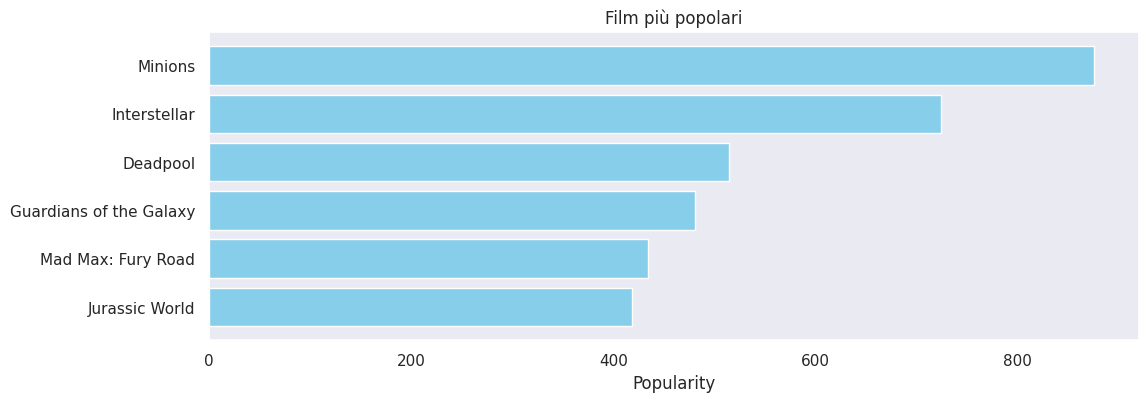

In [53]:
pop=movies.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Film più popolari")

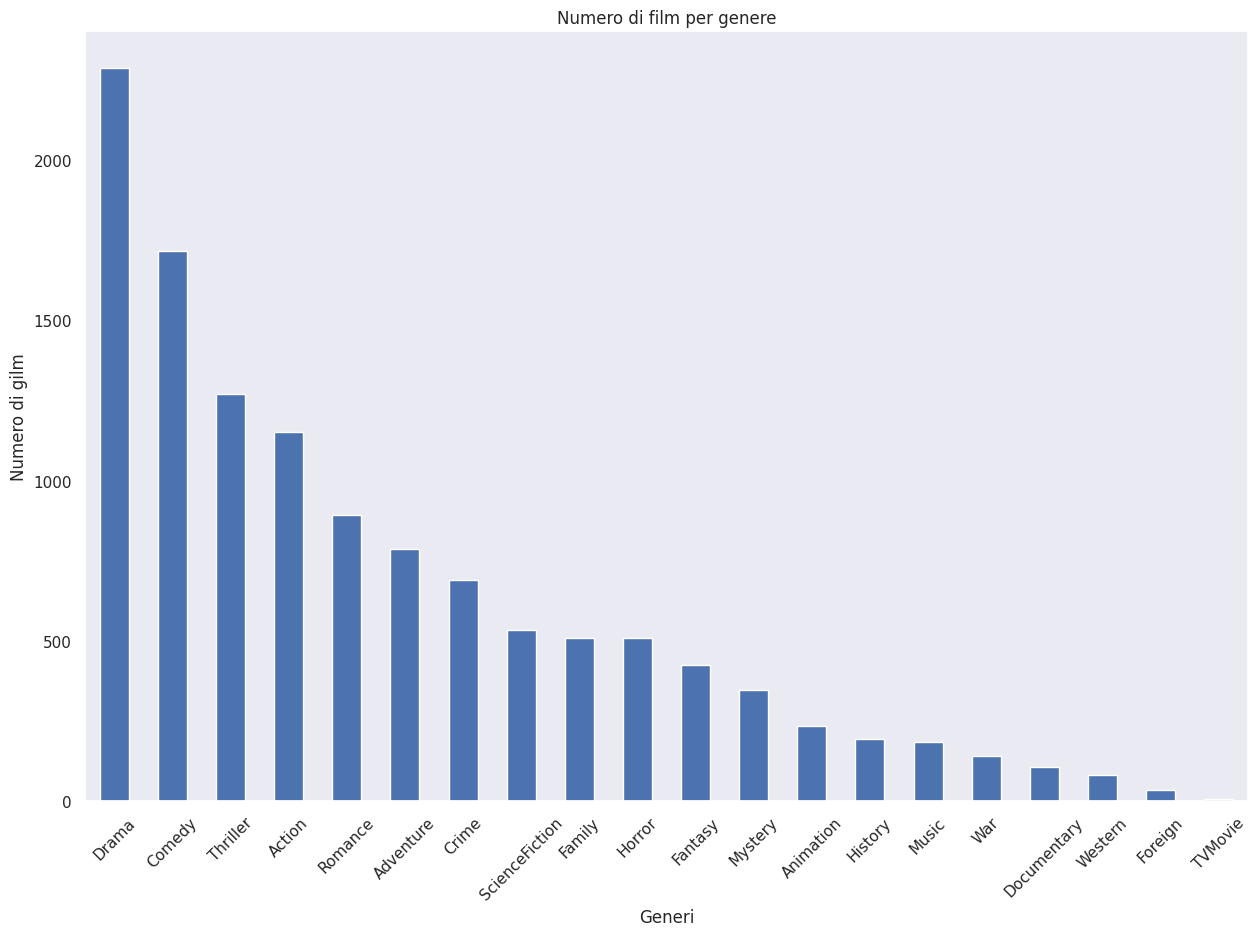

In [54]:
all_genres = movies['genres'].explode()

plt.figure(figsize=(15,10))
all_genres.value_counts().plot(kind='bar')
plt.title('Numero di film per genere')
plt.xlabel('Generi')
plt.ylabel('Numero di gilm')
plt.xticks(rotation=45)
plt.show()

<ipython-input-55-7f5e7807e140>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(movies.corr(),cmap='plasma_r')


Text(0.5, 1.0, 'Matrice di correlazione tra i feature del dataset')

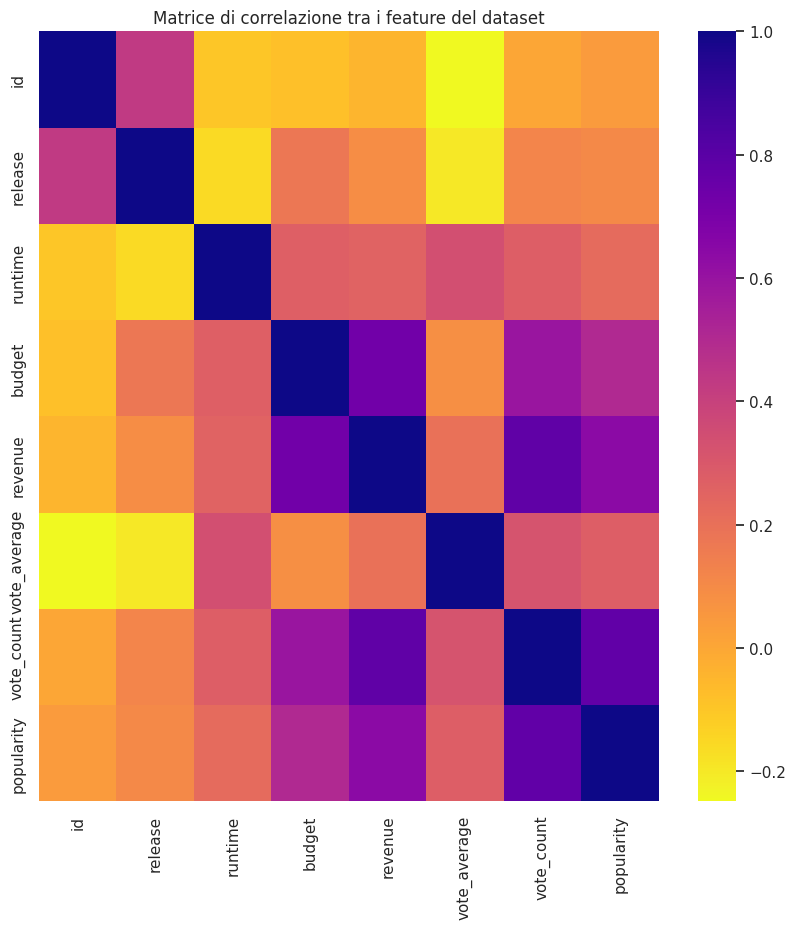

In [55]:
plt.figure(figsize=(10,10))
sns.heatmap(movies.corr(),cmap='plasma_r')
plt.title('Matrice di correlazione tra i feature del dataset')

Text(0.5, 1.0, 'Budget KDE')

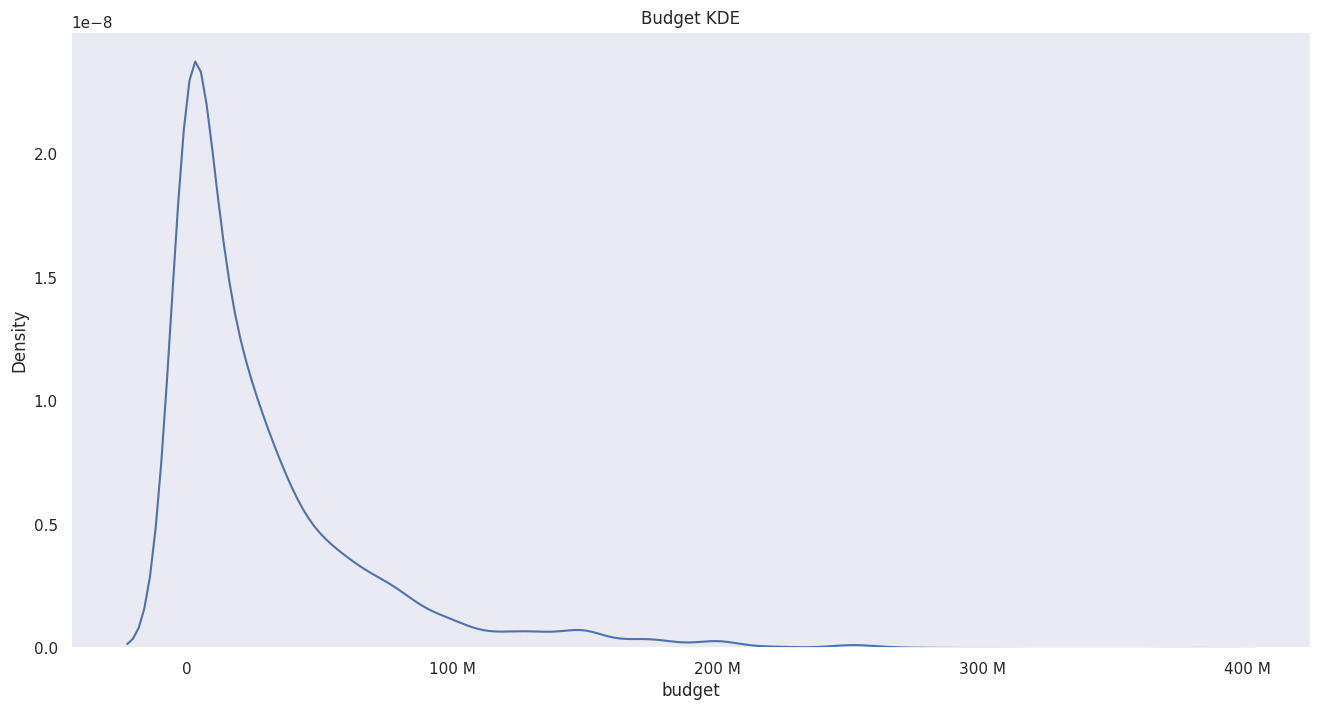

In [56]:
fmt = EngFormatter(places=0)
sns.set_theme(style="dark")

fig, ax = plt.subplots(figsize=(16,8))
fig = sns.kdeplot(data=movies,x='budget')
ax.xaxis.set_major_formatter(fmt)
ax.set_title('Budget KDE')

<ipython-input-57-e8b3b446a6b9>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 400000000], [0, 400000000], 'k-', color = 'r')


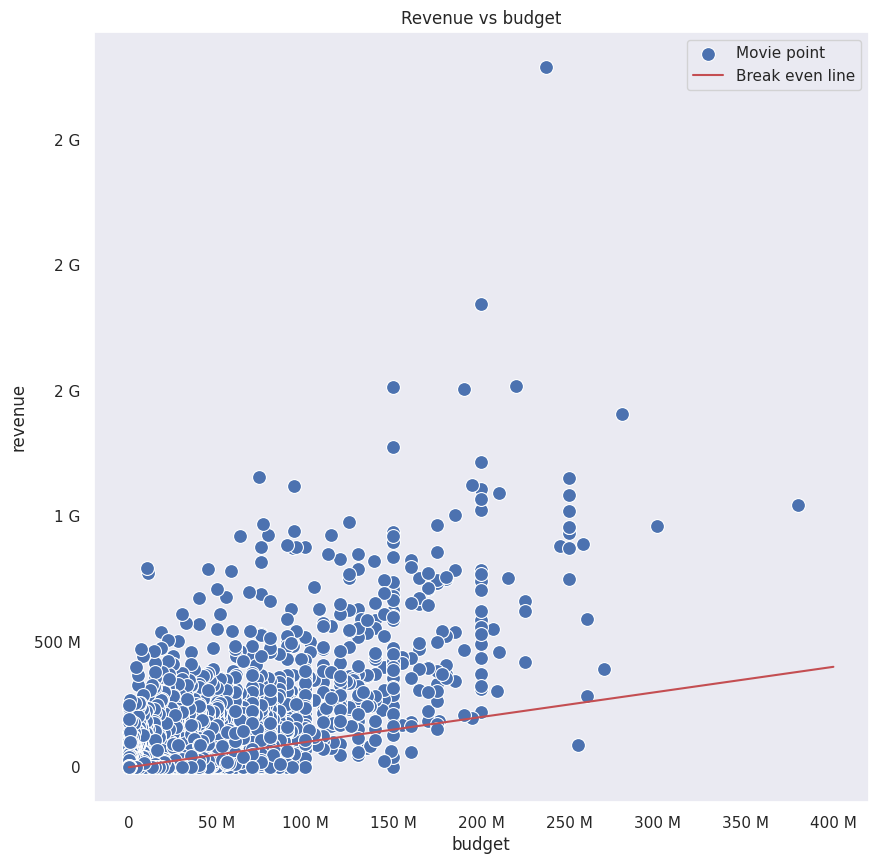

In [57]:
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=movies, x='budget', y='revenue', s=100)
plt.plot([0, 400000000], [0, 400000000], 'k-', color = 'r')
ax.legend(['Movie point','Break even line'])
plt.title('Revenue vs budget')
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)

<Figure size 1700x600 with 0 Axes>

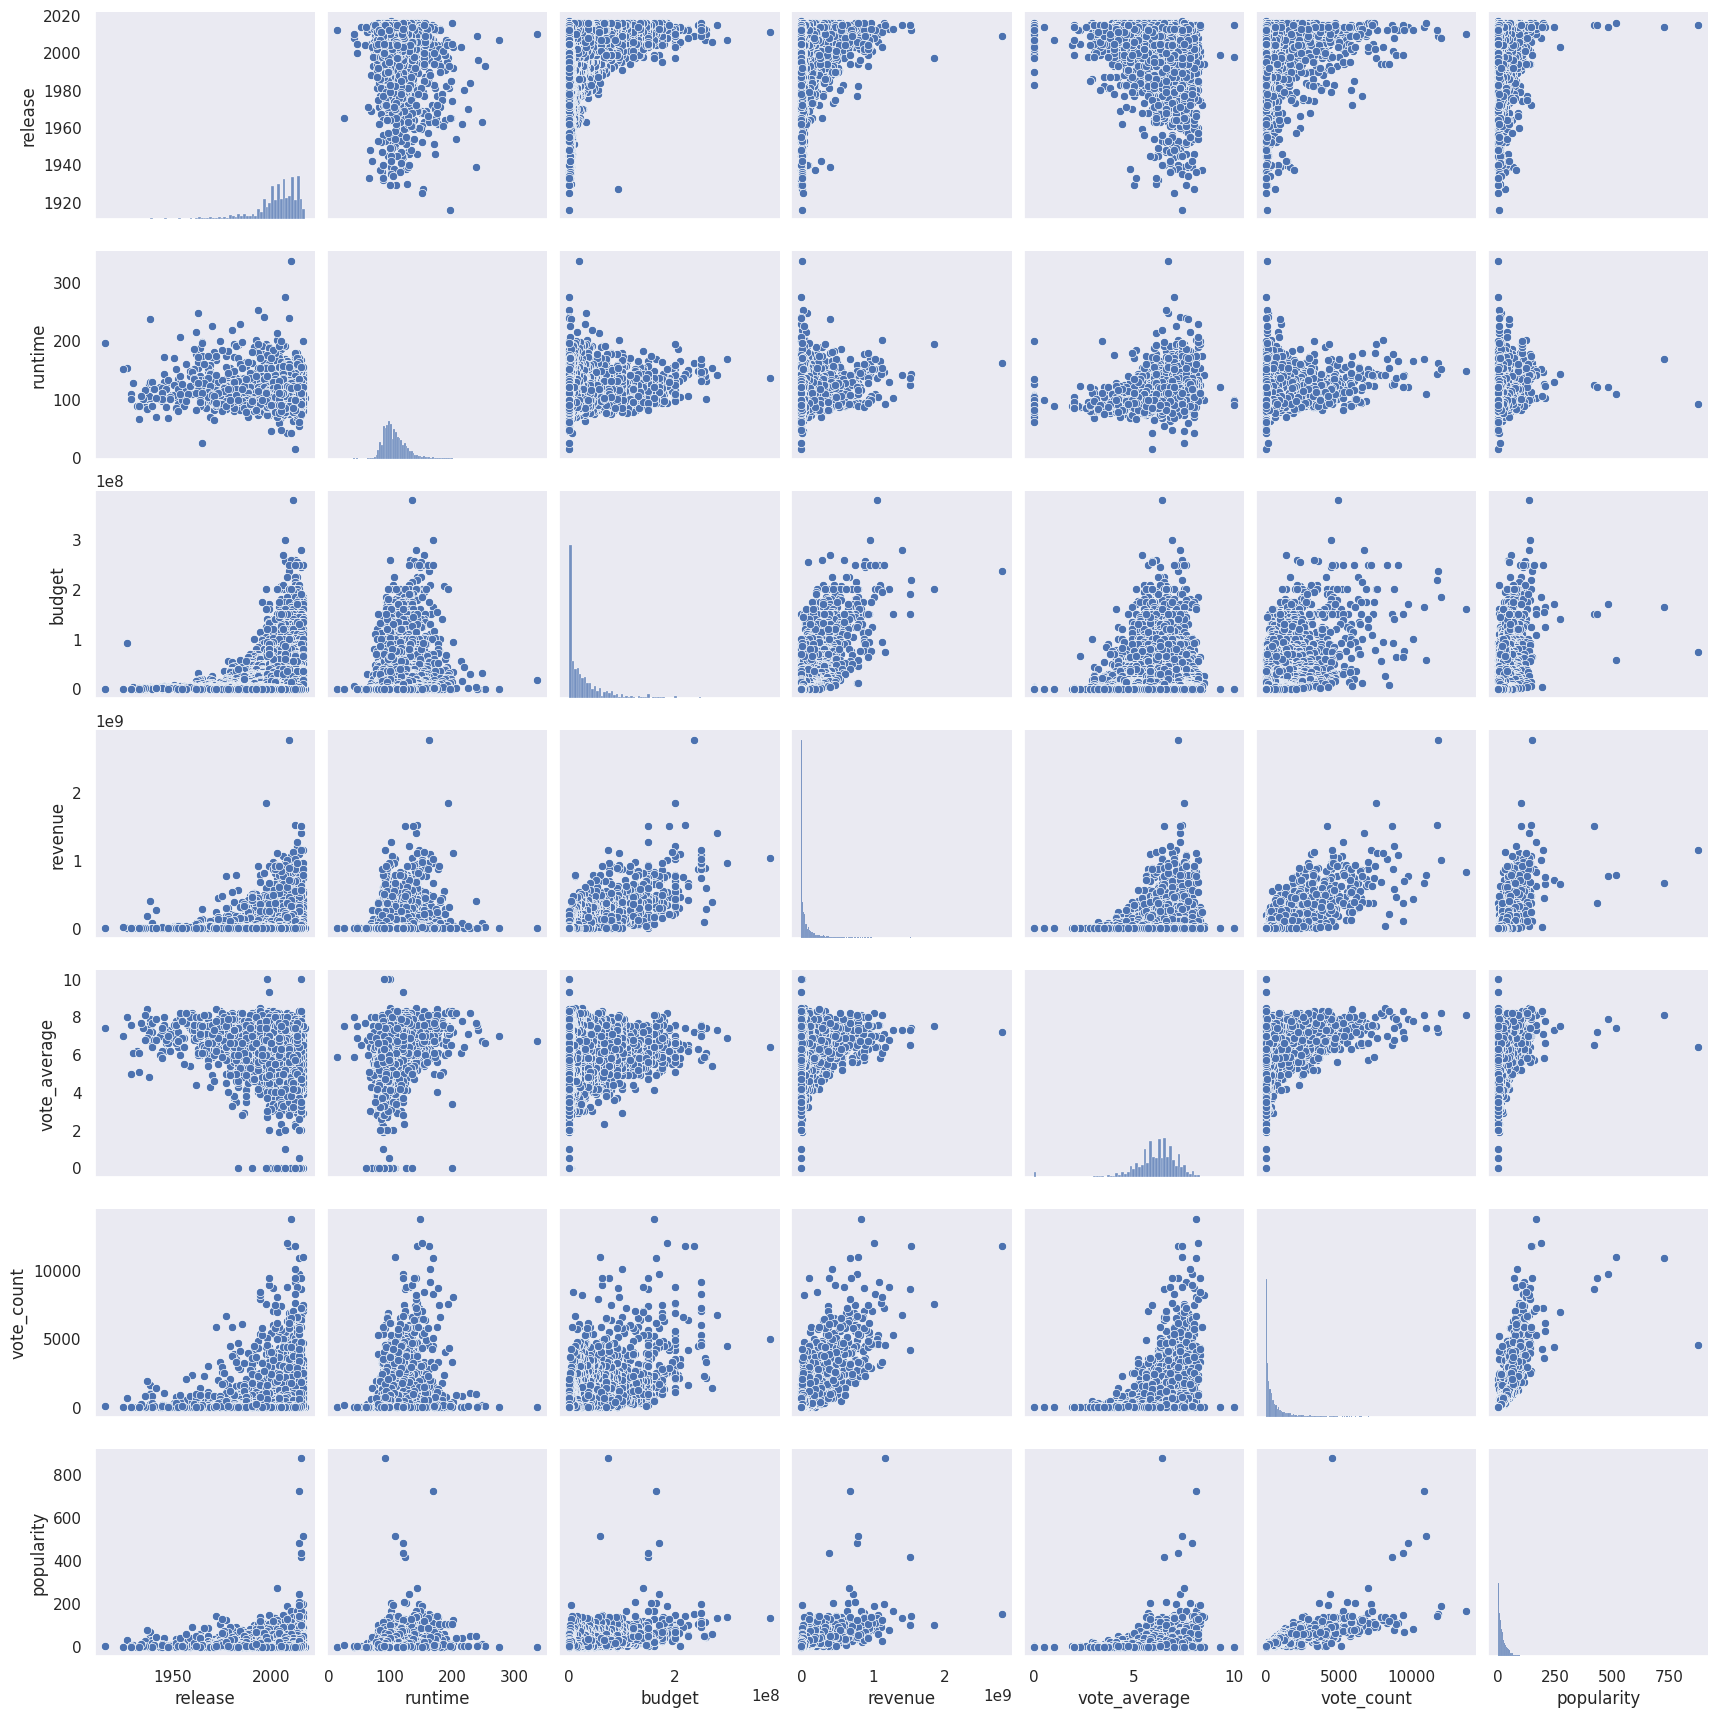

In [58]:
plt.figure(figsize=(17,6))
sns.pairplot(data=movies.drop('id',axis=1))

<ipython-input-59-995088683f5e>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=movies[['title','revenue']].sort_values(by='revenue', ascending=False)['title'][:10], rotation=45, ha='right')


Text(0.5, 1.0, 'Film con incasso più alto')

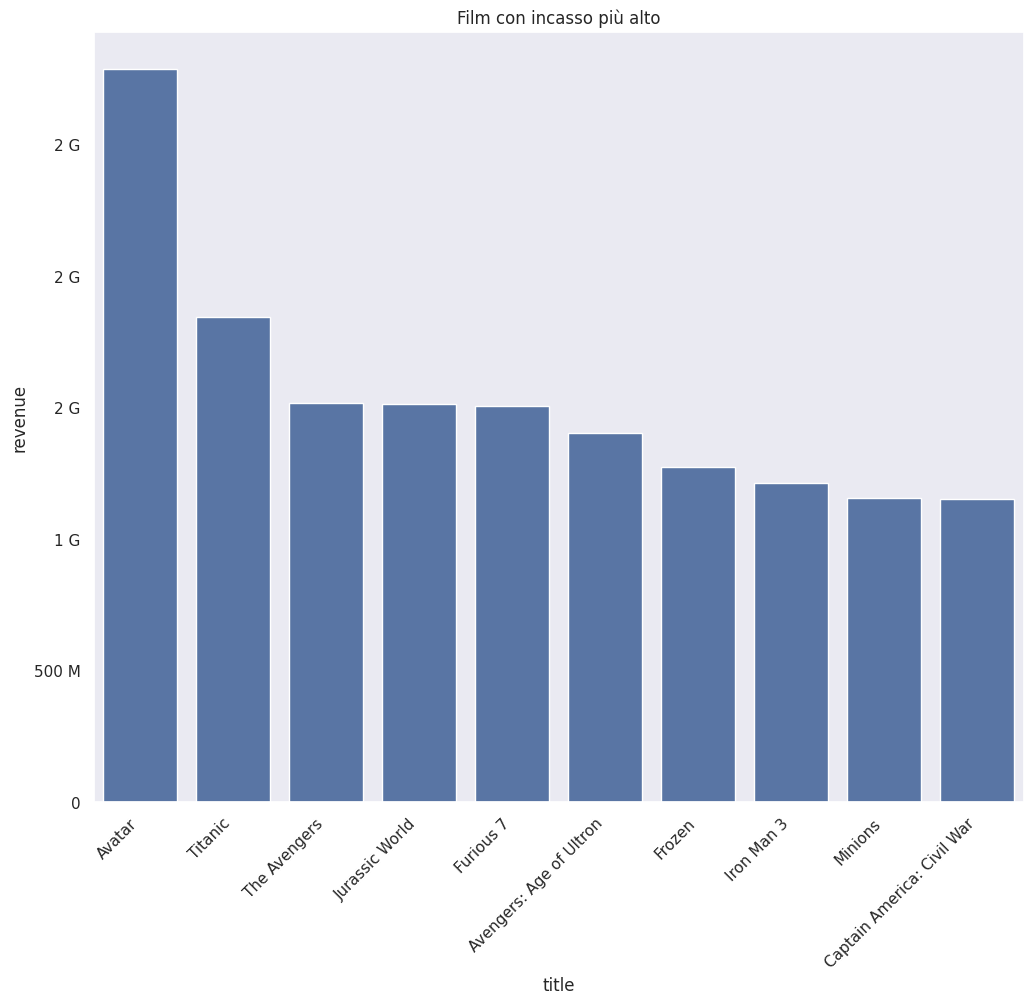

In [59]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(data=movies,x='title',y='revenue', order=movies[['title','revenue']].sort_values(by='revenue', ascending=False)['title'][:10])
ax.set_xticklabels(labels=movies[['title','revenue']].sort_values(by='revenue', ascending=False)['title'][:10], rotation=45, ha='right')
ax.yaxis.set_major_formatter(fmt)
ax.set_title('Film con incasso più alto')

# **Modello ML**

In [60]:
#si crea un dataframe dedicato per il modello di Machine Learning
#che presenta 3 feature, dove in particolare nell'ultima si inseriscono tutte le feature su cui si baserà il suo funzionamento
df_movies = movies[['id', 'title']].copy()
df_movies.loc[:, 'tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

In [61]:
#avendo concatenato più liste, difficili da gestire, si trasforma il campo "tags" in Stringa e
#per facilitare il match, si eliminano dalla stringa tutti i caratteri in Maiuscolo
df_movies['tags'] = df_movies['tags'].apply(lambda x: " ".join(x))
df_movies['tags']= df_movies['tags'].apply(lambda x:x.lower())

In [62]:
#si mostra il risultato delle operazioni
df_movies.head()

,id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."


In [63]:
#con CountVectorizer si effettua la feature extraction, convertendo il testo in una matrice di conteggi di token
#impostando max_features a 5000 per limitare il numero di parole da considerare
#e ‘english’ come stop words per rimuovere le parole comuni in inglese che non aggiungono significato al testo

cv = CountVectorizer(max_features=5000,stop_words='english')
vectors = cv.fit_transform(df_movies['tags']).toarray()

In [64]:
#Si applica al campo tags l'algoritmo di stemming
#per rimuovere i suffissi comuni delle parole, riducendole alla radice

ps=PorterStemmer()
def stem(text):
    Y=[]
    for i in text.split():
        Y.append(ps.stem(i))

    return " ".join(Y)
df_movies['tags']=df_movies['tags'].apply(stem)

In [65]:
#per effettuare Recommendation basandosi sul contenuto, attraverso la metrica della similarità del coseno
#viene istanziata una matrice di similarità che stabilisce quanto un film sia simile ad un altro
#in una scala da 0(meno simile) a 1(più simile)

similarity = cosine_similarity(vectors)

In [66]:
#si mostra per esempio la prima riga della matrice di similarità
similarity[0]

array([1.        , 0.08858079, 0.05812382, ..., 0.02450715, 0.02739983,
       0.        ])

In [67]:
#si definisce la base della funzione di raccomandazione che,
#dato un film in input, restituisce i primi 5 film (escluso il primo perchè è lo stesso)
#più simili in base alla matrice di similarità calcolata prima

def recommend(movie):
    index=movies[movies['title']==movie].index[0]
    distances=similarity[index]
    mlist=sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:6]
    for i in mlist:
        print(movies.iloc[i[0]].title)

# **ML + CSP**

In [68]:
#si definisce la funzione completa di recommend che integra ML e CSP
def recommendML_CSP(movie, genre=None, year=None, runtime=None):

    #funzione "recommend" basata sul ML
    index=movies[movies['title']==movie].index[0]
    distances=similarity[index]
    mlist=sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:1000]
    recommended_movies = [movies.iloc[i[0]].title for i in mlist]

    #se non si fornisce alcun filtro, vengono restituiti direttamente i primi 5 film senza aver bisogno di creare un problema CSP e risolverlo
    if genre is None and year is None and runtime is None:
       return recommended_movies[:5]

    #Si crea il problema CSP
    CSPmovie = Problem()

    #Si aggiungono le variabili al problema
    for movie in recommended_movies:
        CSPmovie.addVariable(movie, [True, False])

    #Si aggiungono i constraint in base ai "filtri" forniti alla funzione
    for movie in recommended_movies:
        m_genres = movies.loc[movies['title'] == movie, 'genres'].values[0]
        m_release_year = movies.loc[movies['title'] == movie, 'release'].values[0]
        m_runtime = movies.loc[movies['title'] == movie, 'runtime'].values[0]

        if genre is not None:
            if year is not None:
                if runtime is not None:
                    CSPmovie.addConstraint(lambda x, g=m_genres, ry=m_release_year, rt=m_runtime:
                                              x if all(gen in g for gen in genre) and
                                                   ry >= year and
                                                   rt >= runtime else not x, [movie])
                else:  # runtime is None
                    CSPmovie.addConstraint(lambda x, g=m_genres, ry=m_release_year:
                                              x if all(gen in g for gen in genre) and
                                                   ry >= year else not x, [movie])
            else:  # year is None
                if runtime is not None:
                    CSPmovie.addConstraint(lambda x, g=m_genres, rt=m_runtime:
                                           x if all(gen in g for gen in genre) and
                                                rt >= runtime else not x, [movie])
                else:  # runtime is None
                    CSPmovie.addConstraint(lambda x, g=m_genres:
                                              x if all(gen in g for gen in genre) else not x, [movie])
        else:  # genre = None
            if year is not None:
                if runtime is not None:
                    CSPmovie.addConstraint(lambda x, ry=m_release_year, rt=m_runtime:
                                           x if ry >= year and
                                                rt >= runtime else not x, [movie])
                else:  # runtime = None
                    CSPmovie.addConstraint(lambda x, ry=m_release_year:
                                           x if ry >= year else not x, [movie])
            else:  # year = None
                if runtime is not None:
                    CSPmovie.addConstraint(lambda x, rt=m_runtime:
                                           x if rt >= runtime else not x, [movie])

    #Si ottengono le soluzioni del problema
    solutions = CSPmovie.getSolutions()

    #Si ricavano solo i film selezionati
    selected_movies = [movie for solution in solutions for movie, selected in solution.items() if selected]

    #Ordinamento:
    #siccome il CSP ritorna soluzioni in ordine alfabetico, verranno ordinati per la feature "score" basata sulla metrica "imDB":
    #ovvero una media ponderata tra media voto del film, e quanti voti ha ricevuto

    #per ordinare per "score", vi è il bisogno di un nuovo dataset con la nuova feature
    c = movies['vote_average'].mean()   #la media di tutte le medie dei film
    m = movies['vote_count'].quantile(0.9)  #minimo numero di voti richiesti affinche film sia elencato
    qualified_movies = movies.copy().loc[movies['vote_count'] >= m]
    qualified_movies['score'] = qualified_movies.apply(lambda x:
                            (x['vote_count'] / (x['vote_count'] + m) * x['vote_average']) +
                            (m / (x['vote_count'] + m) * c), axis=1)

    #Si prendono i film del dataframe "qualified_movies" che corrispondono alle soluzioni CSP,
    #si concatenano in una lista di film ordinata per "score"
    #Per infine riportare i primi 5 film della lista
    #NB: se un film è presente nelle soluzioni CSP, ma non è presente in "qualified_movies", gli verrà assegnato allo score un punteggio di "-inf",
    #il che significa che verrà posizionato alla fine dell’elenco.
    rec_movies = sorted(selected_movies, key=lambda movie: qualified_movies.loc[qualified_movies['title'] == movie, 'score'].values[0]
                        if movie in qualified_movies['title'].values else float('-inf'), reverse=True)
    return rec_movies[0:5]

#esempio di funzionamento
print(recommendML_CSP('Spider-Man', ['Action'], None, None))

['The Dark Knight', 'Inception', 'The Lord of the Rings: The Return of the King', 'The Empire Strikes Back', 'The Lord of the Rings: The Fellowship of the Ring']


# **Interfaccia grafica: applicazione web**

In [69]:
#Per eseguire l'interfaccia grafica è necessario utilizzare i file Python, in quanto non è possibile avviarlo da un Notebook

#1. Assicurarsi di aver installato la libreria streamlit
# pip install streamlit

#2. Posizionarsi nella cartella dei file .py, avviare il terminale, e digitare:
#   streamlit run movierecsys_app.py

#Di seguito verrà riportato il codice del file .py a scopo illustrativo

In [70]:
import streamlit as st
import requests
from movierecsys import recommendML_CSP, movies


#tramite API, si ottiene la copertina di un film dal sito di tmDB, attraverso il suo ID
def fetch_poster(movie_id):
    url = "https://api.themoviedb.org/3/movie/{}?api_key=c7ec19ffdd3279641fb606d19ceb9bb1&language=en-US".format(
        movie_id)
    data = requests.get(url)
    data = data.json()
    poster_path = data['poster_path']
    full_path = "https://image.tmdb.org/t/p/w500/" + poster_path
    return full_path

#si inizializza la lista dei film e dei generi
movies_list = movies['title'].values
genres_list = (movies['genres'].explode().unique()).tolist()

#si inizializza i filtri a None, in modo che se non vengono impostati viene effettuata raccomandazione senza filtri
selected_year = None
selected_genre = None
selected_runtime = None

st.header("Movie Recommender System")
selected_movie = st.selectbox('Scegli un film', movies_list)

hcol1, hcol2, hcol3, hcol4 = st.columns(4)
with hcol1:
    st.markdown("Filtri:")
with hcol2:
    #filtro genere
    if st.toggle('Genere'):
        selected_genre = st.multiselect(" ",genres_list)
with hcol3:
    #filtro anno di uscita
    if st.toggle('Anno di uscita'):
        year_list = list(range(1900, 2017))
        year_list.sort(reverse=True)
        selected_year = st.selectbox(" ",year_list)
with hcol4:
    # filtro durata
    if st.toggle('Durata (minuti)'):
        selected_runtime = st.number_input(" ",min_value=0, max_value=250, step=30)


#funzione "core" dell'interfaccia grafica che, attraverso la funzione dichiarata nel file sorgente principale
#restituisce lista di film raccomandati e copertine
def recommend(movie, genre=None, release=None, runtime=None):
    mlist = recommendML_CSP(movie,genre,release,runtime)
    recommend_movies = []
    recommend_poster = []
    for mov in mlist:
        movies_id = movies[movies['title'] == mov].id.values[0]
        recommend_movies.append(mov)
        recommend_poster.append(fetch_poster(movies_id))
    return recommend_movies, recommend_poster

#funzione che ottiene il link alla homepage del film sul sito tmDB, attraverso il suo nome
def movie_link(movie_name):
    movie_id = movies[movies['title'] == movie_name].id
    id = movie_id.values[0]
    movie = movie_name.lower()
    movie = movie.replace(" ", "-")
    link = f"https://www.themoviedb.org/movie/{id}-{movie}?language=it-IT"
    # esempio link: https://www.themoviedb.org/movie/19995-avatar?language=it-IT
    return link


if st.button('Mostra i film consigliati'):
    movie_name, movie_poster = recommend(selected_movie,selected_genre,selected_year,selected_runtime)
    #si considera il caso che non trova risultati
    if not movie_name:
        st.markdown("Nessun risultato trovato, riprova con altri filtri")
    else:
    #si considera il caso in cui il film potrebbero essere meno di 5
        col = st.columns(5)
        for i in range(len(movie_name)):
            with col[i]:
                link = movie_link(movie_name[i])
                st.page_link(link, label="Info")
                st.image(movie_poster[i])
                st.markdown(f"<p style='text-align: center'>{movie_name[i]}</p>", unsafe_allow_html=True)


#vengono consigliati i film con più incassi al cinema
def recommend_revenue():
    movies_rev = movies.sort_values('revenue', ascending=False)
    mlist_rev = (list(enumerate(movies_rev['id'])))[0:5]
    recommend_rev_movies = []
    recommend_rev_poster = []
    for i in mlist_rev:
        movies_id = movies_rev.iloc[i[0]].id
        recommend_rev_movies.append(movies_rev.iloc[i[0]].title)
        recommend_rev_poster.append(fetch_poster(movies_id))
    return recommend_rev_movies, recommend_rev_poster

st.header("I film più visti al cinema")
movie_rev_name, movie_rev_poster = recommend_revenue()
rcol = st.columns(5)
for i in range(len(movie_rev_name)):
    with rcol[i]:
        link = movie_link(movie_rev_name[i])
        st.page_link(link, label="Info")
        st.image(movie_rev_poster[i])
        st.markdown(f"<p style='text-align: center'>{movie_rev_name[i]}</p>", unsafe_allow_html=True)

#vengono consigliati i film con indice di popolarità più alto
def recommend_popularity():
    movies_pop = movies.sort_values('popularity', ascending=False)
    mlist_pop = (list(enumerate(movies_pop['id'])))[0:5]
    recommend_pop_movies = []
    recommend_pop_poster = []
    for i in mlist_pop:
        movies_id = movies_pop.iloc[i[0]].id
        recommend_pop_movies.append(movies_pop.iloc[i[0]].title)
        recommend_pop_poster.append(fetch_poster(movies_id))
    return recommend_pop_movies, recommend_pop_poster

st.header("I film più popolari")
movie_pop_name, movie_pop_poster = recommend_popularity()
pcol = st.columns(5)
for i in range(len(movie_pop_name)):
    with pcol[i]:
        link = movie_link(movie_pop_name[i])
        st.page_link(link, label="Info")
        st.image(movie_pop_poster[i])
        st.markdown(f"<p style='text-align: center'>{movie_pop_name[i]}</p>", unsafe_allow_html=True)

#vengono consigliati i film più recenti
def recommend_new():
    movies_new = movies.sort_values('release', ascending=False)
    mlist_new = (list(enumerate(movies_new['id'])))[0:5]
    recommend_new_movies = []
    recommend_new_poster = []
    for i in mlist_new:
        movies_id = movies_new.iloc[i[0]].id
        recommend_new_movies.append(movies_new.iloc[i[0]].title)
        recommend_new_poster.append(fetch_poster(movies_id))
    return recommend_new_movies, recommend_new_poster

st.header("Nuove uscite")
movie_new_name, movie_new_poster = recommend_new()
pcol = st.columns(5)
for i in range(len(movie_pop_name)):
    with pcol[i]:
        link = movie_link(movie_new_name[i])
        st.page_link(link, label="Info")
        st.image(movie_new_poster[i])
        st.markdown(f"<p style='text-align: center'>{movie_new_name[i]}</p>", unsafe_allow_html=True)
